# Packaging analysis 

Analysis of how single mutations to the AAV2 capsid affect packaging  
Includes: 
- analysis of library and number of mutations succesful assayed at barcode/codon/amin acid level 
- plots comparing plasmid frequency to codon frequency 
- packaging experiment replicates analysis 
- analysis of stop codon mutations vs WT
- heatmap of all amino acid substituions, insertions and deletions 
- analysis of phylogentic mutation phenotype 

In [1]:
import os 
import sys 

from Bio import AlignIO
import pandas as pd 
pd_idx =pd.IndexSlice
import numpy as np
import seaborn as sns 
import matplotlib
import matplotlib.pyplot as plt
from scipy.stats import variation
from scipy.stats import ks_2samp,mannwhitneyu,pearsonr,variation,ranksums
import scipy.stats as stats

%reload_ext autoreload
%autoreload 2
sys.path.append('../x01_process_data//')
import x02_load_dataframes
import x03_compute_selections
sys.path.append('../settings/')
from paper_settings import PAPER_PRESET
from paper_settings import PAPER_FONTSIZE
from paper_settings import save_fig
sns.set(**PAPER_PRESET)

### load in packaging count data

In [2]:
packaging_counts = x02_load_dataframes.load_packaging_df()
packaging_counts.head()

promoter                                                                                                   CMV  \
source                                                                                                 plasmid   
virus_rep                                                                                                    0   
tech_rep                                                                                                   p-a   
measurement                                                                                              count   
gen_id                                                                                             GEN00105092   
abs_pos tile_num aa is_wt_aa is_wt_codon wt_bc lib_type enzyme codon aa-codon barcode                            
1.0     0.0      *  0        0           0     sub      bbsi   TAA   *-TAA    CACTGTCACACACTGACACT       574.0   
                                                                              CTGTGAGTGTGAGAGACACT       685.0   
                                                               TAG   *-TAG    CTCTCACACAGTGAGTCTGA       112.0   
                                                                              CAGAGACAGAGTCTGTCACT       128.0   
                                                               TGA   *-TGA    ACACTGTCTCTGTCAGACAG      1077.0   

promoter                                                                                                        \
source                                                                                                           
virus_rep                                                                                                        
tech_rep                                                                                                   p-b   
measurement                                                                                              count   
gen_id                                                                                             GEN00113847   
abs_pos tile_num aa is_wt_aa is_wt_codon wt_bc lib_type enzyme codon aa-codon barcode                            
1.0     0.0      *  0        0           0     sub      bbsi   TAA   *-TAA    CACTGTCACACACTGACACT       556.0   
                                                                              CTGTGAGTGTGAGAGACACT       600.0   
                                                               TAG   *-TAG    CTCTCACACAGTGAGTCTGA        59.0   
                                                                              CAGAGACAGAGTCTGTCACT       145.0   
                                                               TGA   *-TGA    ACACTGTCTCTGTCAGACAG      1127.0   

promoter                                                                                                        \
source                                                                                                           
virus_rep                                                                                                        
tech_rep                                                                                                   p-c   
measurement                                                                                              count   
gen_id                                                                                             GEN00113848   
abs_pos tile_num aa is_wt_aa is_wt_codon wt_bc lib_type enzyme codon aa-codon barcode                            
1.0     0.0      *  0        0           0     sub      bbsi   TAA   *-TAA    CACTGTCACACACTGACACT       560.0   
                                                                              CTGTGAGTGTGAGAGACACT       603.0   
                                                               TAG   *-TAG    CTCTCACACAGTGAGTCTGA        94.0   
                                                                              CAGAGACAGAGTCTGTCACT        96.0   
        

### how often each mutation is seen in terms of amino acid / codon / barcode 

In [3]:
packaging_counts_plasmid = packaging_counts.loc[:,pd_idx['CMV','plasmid','0']].sum(axis=1).reset_index()
barcodes_seen = packaging_counts_plasmid[packaging_counts_plasmid[0]>0][0].count()
barcodes_total = float(packaging_counts_plasmid[0].count())
barcodes_percent = barcodes_seen / barcodes_total
print ("%s barcodes seen of %s total barcodes, Percent: %.3f" % (barcodes_seen,barcodes_total,100*barcodes_percent))

203761 barcodes seen of 207168.0 total barcodes, Percent: 98.355


In [4]:
packaging_counts_plasmid = packaging_counts.loc[:,pd_idx['CMV','plasmid','0']].sum(axis=1).reset_index()
barcodes_seen = packaging_counts_plasmid[packaging_counts_plasmid[0]>0][0].count()
barcodes_total = float(packaging_counts_plasmid[0].count())
barcodes_percent = barcodes_seen / barcodes_total
print ("%s barcodes seen of %s total barcodes, Percent: %.3f" % (barcodes_seen,barcodes_total,100*barcodes_percent))

203761 barcodes seen of 207168.0 total barcodes, Percent: 98.355


In [5]:
codon_count = packaging_counts_plasmid.groupby(['abs_pos', 'codon','tile_num'])[0].sum()
print ("%s codons seen of %s total codons, Percent: %.3f" % (
    codon_count[codon_count>0].count(), codon_count.count() , 100*(codon_count[codon_count>0].count() / float(codon_count.count()))))

94054 codons seen of 94110 total codons, Percent: 99.940


In [6]:
aa_count = packaging_counts_plasmid.groupby(['abs_pos', 'aa','tile_num'])[0].sum()
print ("%s AA seen of %s total AA, Percent: %.3f" % (
    aa_count[aa_count>0].count(), aa_count.count() , 100*(aa_count[aa_count>0].count() / float(aa_count.count()))))

31598 AA seen of 31599 total AA, Percent: 99.997


### distribution of counts (Fig. S2A)

Total Reads: 1.344e+08
Average read number per barcode: 6.487e+02


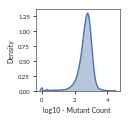

In [7]:
fig,ax =plt.subplots(figsize=(1.5,1.5))

sns.distplot(packaging_counts_plasmid[packaging_counts_plasmid[0]>0][0].dropna().apply(np.log10), ax=ax)
ax.set_xlabel('log10 - Mutant Count ')
ax.set_ylabel('Density')

print ("Total Reads: %.3e" % packaging_counts_plasmid[0].sum())
print ("Average read number per barcode: %.3e"  % packaging_counts_plasmid[0].mean())

### Comparison of plasmid frequency to count frequency (Fig. 1B)

In [8]:
def correlation_plot(x, y,
                     scatter_kwargs={}, plot_kwargs={}):
    plt.scatter(x, y, **scatter_kwargs)
    slope, intercept, r_value, p_value, std_err = stats.linregress(x, y)
    line_x = np.arange(-8.5,-2.5)
    line_y = slope*line_x + intercept
    plt.plot(line_x, line_y, **plot_kwargs)

first determine the frequencies for plotting, along with wilt type normalziation for point color

In [9]:
package_counts_summed_freq = packaging_counts.groupby(
    level=['promoter', 'source'],axis=1).sum().apply(
    lambda x: x/sum(x)).xs('CMV', level='promoter', axis=1).apply(np.log10).replace([np.inf, -np.inf], np.nan).dropna()

package_counts_summed_freq['selection'] = package_counts_summed_freq['virus'] - package_counts_summed_freq['plasmid']
package_counts_summed_freq['selection_wt_norm'] = package_counts_summed_freq['selection']- package_counts_summed_freq['selection'].xs(1,level='wt_bc').mean()
package_counts_summed_freq_sample = package_counts_summed_freq.sample(20000, random_state=100)
package_counts_summed_freq_sample.head()

,,,,,,,,,,source,plasmid,virus,selection,selection_wt_norm
abs_pos,tile_num,aa,is_wt_aa,is_wt_codon,wt_bc,lib_type,enzyme,codon,aa-codon,barcode,,,,
526.0,13.0,I,0,0,0,sub,bbsi,ATA,I-ATA,TGTGACAGAGACAGACACAC,-5.354551,-4.394210,0.960341,0.509791
525.0,13.0,S,0,0,0,sub,bbsi,AGT,S-AGT,GTCACTCAGTCACTGACTGA,-5.588008,-4.968020,0.619988,0.169437
50.0,1.0,I,0,0,0,sub,bbsi,ATA,I-ATA,CACACACTCAGAGTCTGACA,-5.935213,-6.445142,-0.509929,-0.960479
675.5,17.0,Y,0,0,0,ins,bbsi,TAC,Y-TAC,CTGTGTGAGAGTCTGTCTGA,-5.661470,-7.059791,-1.398321,-1.848871
636.0,16.0,D,0,0,0,sub,bbsi,GAC,D-GAC,TGTCTGAGTCACACTGTCAC,-5.737402,-7.445142,-1.707739,-2.158290


In [10]:
package_counts_summed_freq_wt_barcodes = package_counts_summed_freq.xs(1, level='wt_bc')

(-8, -3)

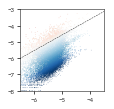

In [11]:
fig,ax =plt.subplots(figsize=(1.5,1.5))

plt.scatter(package_counts_summed_freq_sample['plasmid'], package_counts_summed_freq_sample['virus'], 
            c=package_counts_summed_freq_sample['selection_wt_norm'],cmap='RdBu_r', s= .1,alpha=.5,vmin=-2, vmax=2)
correlation_plot(package_counts_summed_freq_wt_barcodes['plasmid'],package_counts_summed_freq_wt_barcodes['virus'], 
                scatter_kwargs={'s':.1,'c':'white','alpha':.3,'label':'WT codons'}, 
                 plot_kwargs= {'c':'black','linestyle':'dashed','alpha':.8,'lw':.5})
plt.xlim(-6.5, -3.5)
plt.ylim(-8, -3)

## Replicate analsysis (Fig. S2B-D)

In [12]:
package_bio_replicates_selection = x03_compute_selections.compute_packaging_selection(
    packaging_counts,level='codon', wt_norm=True, sum_measurments=False, for_plotting=False)
package_bio_replicates_selection.head()

CMV  \
                                                                                  virus   
                                                                                      1   
abs_pos tile_num aa is_wt_aa is_wt_codon wt_bc lib_type enzyme codon aa-codon             
1.0     0.0      *  0        0           0     sub      bbsi   TAA   *-TAA     0.214813   
                                                               TAG   *-TAG     0.196879   
                                                               TGA   *-TGA     0.168971   
                 -  0        0           0     del      bbsi   ---   -----     0.169594   
                 A  0        0           0     sub      bbsi   GCA   A-GCA     0.192496   

                                                                                         \
                                                                                          
                                                                                      2   
abs_pos tile_num aa is_wt_aa is_wt_codon wt_bc lib_type enzyme codon aa-codon             
1.0     0.0      *  0        0           0     sub      bbsi   TAA   *-TAA     0.179319   
                                                               TAG   *-TAG     0.107946   
                                                               TGA   *-TGA     0.144022   
                 -  0        0           0     del      bbsi   ---   -----     0.305526   
                 A  0        0           0     sub      bbsi   GCA   A-GCA     0.148303   

                                                                                    Rep  \
                                                                                  virus   
                                                                                      3   
abs_pos tile_num aa is_wt_aa is_wt_codon wt_bc lib_type enzyme codon aa-codon             
1.0     0.0      *  0        0           0     sub      bbsi   TAA   *-TAA     0.238270   
                                                               TAG   *-TAG     0.183849   
                                                               TGA   *-TGA     0.206508   
                 -  0        0           0     del      bbsi   ---   -----     0.024670   
                 A  0        0           0     sub      bbsi   GCA   A-GCA     0.071771   

                                                                                         \
                                                                                          
                                                                                      4   
abs_pos tile_num aa is_wt_aa is_wt_codon wt_bc lib_type enzyme codon aa-codon             
1.0     0.0      *  0        0           0     sub      bbsi   TAA   *-TAA     0.225661   
                                                               TAG   *-TAG     0.155891   
                                                               TGA   *-TGA     0.179436   
                 -  0        0           0     del      bbsi   ---   -----          NaN   
                 A  0        0           0     sub      bbsi   GCA   A-GCA     0.077652   

                                                                                         \
                                                                                          
                                                                                     14   
abs_pos tile_num aa is_wt_aa is_wt_codon wt_bc lib_type enzyme codon aa-codon             
1.0     0.0      *  0        0           0     sub      bbsi   TAA   *-TAA     0.796651   
                                                               TAG   *-TAG          NaN   
                                                               TGA   *-TGA          NaN   
                 -  0        0           0     del      bbsi   ---   -----          NaN   
                 A  0        0           0     sub      bbsi   GCA   A-GCA  

### compare CMV-AAV2 lib production replicaties

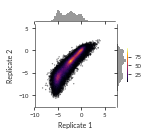

In [13]:
cmap=plt.cm.jet
joint_kws=dict(gridsize=200, cmap='inferno', mincnt=2,alpha=.5)
marginal_kws=dict(color='black')

fig = plt.figure(figsize=[1.3,1.3])
g = sns.jointplot(x=('CMV', 'virus', '1'), 
              y=('CMV', 'virus', '2') ,size=2,ratio=6,
              data=package_bio_replicates_selection.apply(np.log2),
              kind='hex',color='black',joint_kws=joint_kws,marginal_kws=marginal_kws,stat_func=None)
g.set_axis_labels('Replicate 1', 'Replicate 2')

cb = plt.colorbar(ticks=[1,25,50,75,100,125,150])
cb.outline.set_visible(False)
plt.show()

### compare Rep-AAV2 lib production replicaties

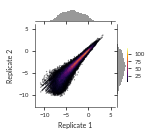

In [14]:
cmap=plt.cm.jet
joint_kws=dict(gridsize=200, cmap='inferno', mincnt=2,alpha=.5)
marginal_kws=dict(color='black')

fig = plt.figure(figsize=[1.3,1.3])
g = sns.jointplot(x=('Rep', 'virus', '3'), 
              y=('Rep', 'virus', '4'), 
              data=package_bio_replicates_selection.apply(np.log2),
              kind='hex',color='black',joint_kws=joint_kws,marginal_kws=marginal_kws,size=2,ratio=6, stat_func=None)
g.set_axis_labels('Replicate 1', 'Replicate 2')

cb = plt.colorbar(ticks=[1,25,50,75,100,125,150])
cb.outline.set_visible(False)
plt.show()

### compare Rep-AAV2 vs CMV-AAV2 lib production replicaties

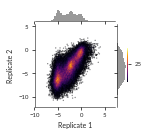

In [15]:
cmap=plt.cm.jet
joint_kws=dict(gridsize=200, cmap='inferno', mincnt=2,alpha=.5)
marginal_kws=dict(color='black')

fig = plt.figure(figsize=[1.3,1.3])
g = sns.jointplot(x=('CMV', 'virus', '1'), 
              y=('Rep', 'virus', '3'), 
              data=package_bio_replicates_selection.apply(np.log2),
              kind='hex',color='black',joint_kws=joint_kws,marginal_kws=marginal_kws,size=2,ratio=6, stat_func=None)
g.set_axis_labels('Replicate 1', 'Replicate 2')

cb = plt.colorbar(ticks=[1,25,50,75,100,125,150])
cb.outline.set_visible(False)
plt.show()

## Wildtype Vs VP1/2/3 Stops (Fig. 1C)

In [16]:
package_barcode_full_sum = x03_compute_selections.compute_packaging_selection(
    packaging_counts,level='barcode', wt_norm=True, sum_measurments=True, for_plotting=False)

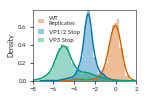

In [17]:
set_2_colors = sns.color_palette("colorblind")
VP2_START = 139
VP3_START = 204
cmv_data = package_barcode_full_sum.xs('CMV', level=0, axis=1,drop_level=False)
WT = cmv_data.query("wt_bc==1").apply(
    np.log2).dropna().values
VP12_stops = cmv_data.query("(abs_pos < @VP3_START) & (aa == '*')").apply(
    np.log2).dropna().values
VP3_stops = cmv_data.query("(abs_pos > @VP3_START) & (aa == '*')").apply(
    np.log2).dropna().values

fig = plt.figure(figsize=(1.86, 1.3))
g = sns.distplot(WT,bins=50, label='WT\nReplicates',color=set_2_colors[2])
sns.distplot(VP12_stops, bins=50, label='VP1/2 Stop',color=set_2_colors[0])
sns.distplot(VP3_stops, bins=50,label='VP3 Stop',color=set_2_colors[1])
g.set_xlabel("")
g.set_ylabel("Density")
g.set_xlim((-8,2))

plt.legend(frameon=False,columnspacing=.1,handlelength=1,fontsize=6)

## effect sizes for difference WT vs stop difference

In [18]:
np.median(WT.flatten())

-0.09012982882751788

In [19]:
np.median(VP3_stops.flatten())

-4.817610034282405

In [20]:
np.median(VP12_stops.flatten())

-2.62732137476437

log2 mean difference WT vs VP3 stops

In [21]:
np.median(WT.flatten()) - np.median(VP3_stops.flatten())

4.727480205454887

log2 mean difference WT vs VP12 stops

In [22]:
np.median(WT.flatten()) - np.median(VP12_stops.flatten())

2.537191545936852

### Calculate p-values and CVs

In [23]:
mannwhitneyu(WT.flatten(), VP3_stops.flatten())

MannwhitneyuResult(statistic=23408.0, pvalue=7.04760690822782e-219)

In [24]:
mannwhitneyu(WT, VP12_stops)

MannwhitneyuResult(statistic=16537.5, pvalue=2.114440679332685e-172)

In [25]:
variation(2**WT)

array([0.58699533])

In [26]:
package_barcode_full_sum.xs(1,level='wt_bc').describe()

CMV         Rep                      
                0           0         14         15
count  398.000000  395.000000  22.000000  23.000000
mean     1.000000    1.000000   1.000000   1.000000
std      0.587734    0.823701   1.604742   1.164592
min      0.014205    0.028950   0.039417   0.034400
25%      0.701123    0.434144   0.264859   0.332415
50%      0.939439    0.780613   0.519877   0.528650
75%      1.204042    1.303773   0.679451   1.149138
max      8.829868    4.961226   7.184614   4.196099

## Amino Acid Heatmap (Fig. 1D)

In [27]:
package_aa_full_sum = x03_compute_selections.compute_packaging_selection(
    packaging_counts,level='aa', wt_norm=True, sum_measurments=True, for_plotting=True)

In [28]:
DESIRED_AA_ORD = ["-","I", "L", "V", "A", "G", "M", "F", "Y", "W", "E", 
                    "D", "Q", "N", "H", "C", "R", "K", "S", "T", "P", "*"]

data shaping for heatmap generation

In [29]:
sub_del = package_aa_full_sum.query("lib_type.isin(['sub','del'])").xs('CMV', level=0,axis=1)
sub_del.index = sub_del.index.droplevel(['lib_type', 'is_wt_aa'])
sub_del_matrix = sub_del.groupby(level=[0,1]).mean().unstack(0)
sub_del_matrix.columns = sub_del_matrix.columns.droplevel(0)
sub_del_matrix_aa_ordered = sub_del_matrix.reindex(DESIRED_AA_ORD)
ins_df = package_aa_full_sum.query("lib_type.isin(['ins'])").xs(('CMV','0'), level=[0,1],axis=1,drop_level=True)
ins_df.index = ins_df.index.droplevel(['lib_type', 'is_wt_aa'])
ins_df.reset_index(inplace=True)
ins_df['abs_pos'] = ins_df['abs_pos'] -.5
ins_df.set_index(['abs_pos', 'aa'], inplace=True)
ins_df_matrix = ins_df.unstack(0)
ins_df_matrix_ordered = ins_df_matrix.reindex(DESIRED_AA_ORD)
ins_df_matrix_ordered.columns = ins_df_matrix_ordered.columns.droplevel([0,1])
ins_df_matrix_ordered.dropna(inplace=True)
ins_subs_stacked = pd.concat([ins_df_matrix_ordered,sub_del_matrix_aa_ordered])

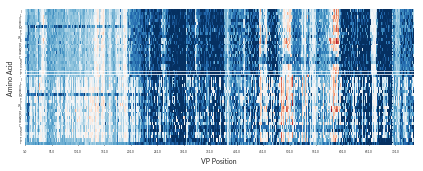

In [30]:
fig,ax = plt.subplots(figsize = [8,2.5])
g = sns.heatmap(ins_subs_stacked.apply(np.log2),vmin=-5,vmax=5,
                cmap='RdBu_r',cbar=None,xticklabels=50,yticklabels=1)
ax.tick_params(labelsize=3,rotation=0)

fig.subplots_adjust(right=0.8)

plt.plot([0,735],[19,19], c='white',linewidth=.75)
plt.plot([0,735],[20,20], c='white',linewidth=.75)
ax.set_xlabel('VP Position',size=PAPER_FONTSIZE)
ax.set_ylabel('Amino Acid', size=PAPER_FONTSIZE)
ax.tick_params(length=.5)

Text(0,0.5,'log2(selection)')

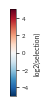

In [31]:
a = np.array([[-5,5]])
fig = plt.figure(figsize=(.1, 2))
img = plt.imshow(a, cmap="RdBu_r")
plt.gca().set_visible(False)
cax = plt.axes([0.1, 0.2, 0.8, 0.6])
plt.colorbar( cax=cax)
plt.ylabel('log2(selection)')
# save_fig(fig, 'heatmap_colorbar.pdf',transparent=True)

## Variable region analysis

In [32]:
VR_1 = np.arange(262,269,.5)
VR_2 = np.arange(326,331,.5)
VR_3 = np.arange(380, 389,.5)
VR_4 = np.arange(449,469,.5)
VR_5 = np.arange(487,504,.5)
VR_6 = np.arange(525,540,.5)
VR_7 = np.arange(544,556,.5)
VR_8 = np.arange(579, 594,.5)
VR_9 = np.arange(704,711,.5)

VR_LIST = np.concatenate([VR_1,VR_2,VR_4,VR_5,VR_6,VR_7,VR_8,VR_9])


In [33]:
vr_df = package_aa_full_sum.query("abs_pos in (@VR_LIST) & is_wt_aa==0").iloc[
    :,0].dropna().apply(np.log2)
conserved_df =package_aa_full_sum.query("(abs_pos not in (@VR_LIST)) & \
    (abs_pos > 211)  & is_wt_aa ==0").iloc[:,0].dropna().apply(np.log2)

In [34]:
vr_array = vr_df.values
conserved_array = conserved_df.dropna().values
vr_array.shape

(4115,)

In [35]:
conserved_array.shape

(17893,)

## Serotype Comparison (Fig. 1F)

determine alignment positions relative to AAV2 capsid position

In [39]:
AAV_alignments = AlignIO.parse('../data/meta/AAV_protein_alignment.phy','phylip')

def calculate_aligment_positions(alignment_in):
    alignment_obj = []
    alignment_df = pd.DataFrame()
    for alignment in alignment_in:
        for idx, seq_obj in enumerate(alignment):
            protein_position=1
            for alignment_position, aa in enumerate(seq_obj.seq):
                if aa == '-':
                    protein_position_write = 0
                else:
                    protein_position_write = protein_position
                alignment_obj.append({'align_pos':alignment_position+1,
                                      '%s_pos' % seq_obj.id :protein_position_write, 
                                      '%s_aa' % seq_obj.id: aa})
                if aa != '-':
                    protein_position +=1

            df = pd.DataFrame(alignment_obj)
            if idx == 0:
                alignment_df = pd.DataFrame(alignment_obj)
            else:
                alignment_df = alignment_df.merge(df, on=['align_pos'], how='left')
            alignment_obj = []
    return alignment_df.set_index('align_pos')

alignment_df = calculate_aligment_positions(AAV_alignments)
# alignment_df

In [40]:
def get_residue_differences(alignemnt_df):
    aav_diffs = []

    for idx, row in alignment_df.iterrows():
        aav2_aa =  row['aav2_aa']
        aav2_pos = row['aav2_pos']
        for sidx, val in row.iteritems():
            if type(val) is str:
                if val != aav2_aa:
                    aav_diffs.append({'abs_pos': aav2_pos, 'aa':val})
    return pd.DataFrame(aav_diffs).drop_duplicates()

differences_aav_seroptypes_df = get_residue_differences(alignment_df)
differences_aav_seroptypes_df.shape

(960, 2)

In [41]:
alignment_aa = alignment_df[[x for x in alignment_df.columns if '_aa' in x]]
alignment_aa
conservation = []
for idx, row in alignment_aa.iterrows():
    conservation.append(1 - len(row.unique()) / float(row.count()))

In [42]:
aav2_cons = pd.concat([alignment_df['aav2_pos'], pd.DataFrame(conservation)],axis=1)
aav2_cons[aav2_cons['aav2_pos'] != 0].dropna()[0].to_csv('../data/meta/conservation.csv', index=False)

In [43]:
def subset_fitness_residues(diff_df, fitness_df):
    serotype_fitness_df = pd.DataFrame()
    for idx, row in diff_df.iterrows():
        if row['abs_pos'] == 0:
            continue
        value = fitness_df.xs([row['aa'], row['abs_pos']], level=['aa', 'abs_pos'], drop_level=False)
        serotype_fitness_df = pd.concat([serotype_fitness_df, value])
    return serotype_fitness_df
serotype_fitness_df = subset_fitness_residues(differences_aav_seroptypes_df, package_aa_full_sum)

In [44]:
non_vr_other_serotypes = serotype_fitness_df.query("abs_pos not in @VR_LIST").iloc[:,0].dropna().apply(np.log2)
vr_other_serotypes = serotype_fitness_df.query("abs_pos  in @VR_LIST").iloc[:,0].dropna().apply(np.log2)

In [45]:
vr_df_not_in_other_serotypes = vr_df[~vr_df.isin(vr_other_serotypes)]

In [46]:
def melt_for_box_plot(vr_df, sero_df, cons_df, sero_vr_df):
    vr_df_plot  = vr_df.reset_index()
    vr_df_plot['type'] = 'VR-All'
    sero_df_plot = sero_df.reset_index()
    sero_df_plot['type'] = 'Serotypes\n(VR-)'
    cons_df_plot = cons_df.reset_index()
    cons_df_plot['type'] = 'Conserved'
    sero_vr_df_plot = sero_vr_df.reset_index()
    sero_vr_df_plot['type'] = 'Serotypes\n(VR+)'

    
    return pd.concat([vr_df_plot, sero_df_plot, cons_df_plot,sero_vr_df_plot])

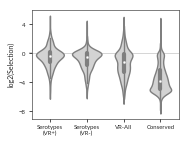

In [47]:
fig, ax =plt.subplots(figsize=[2.64,2])
fit_df = melt_for_box_plot(vr_df, non_vr_other_serotypes, conserved_df,vr_other_serotypes)
sns.violinplot(x='type', y=('CMV', '0'),order=['Serotypes\n(VR+)',
                                           'Serotypes\n(VR-)',
                                           'VR-All',
                                           'Conserved'] , data=fit_df, color='lightgray')

plt.ylabel('log2(Selection)')
plt.xlabel('')
plt.yticks([-8,-4,0,4])
plt.ylim((-9, 6))
ax.set_yticks([0], minor=True)
ax.yaxis.grid(True, which='minor')


In [48]:
pvals=[]
for col_1 in fit_df['type'].unique():
    for col_2 in fit_df['type'].unique():
        if col_1==col_2 : continue
        col_1_data = fit_df[fit_df['type'] == col_1][('CMV', '0')]
        col_2_data = fit_df[fit_df['type'] == col_2][('CMV', '0')]
        pvals.append({'col_1':col_1, 'col_2':col_2,
                      'mannpval': mannwhitneyu(col_1_data, col_2_data)[1],
                     'ks_pval': stats.ks_2samp(col_1_data, col_2_data)[1], 
                      'effect_size':np.median(col_1_data) - np.median(col_2_data) })
pd.DataFrame(pvals)

,col_1,col_2,effect_size,ks_pval,mannpval
0,VR-All,Serotypes\n(VR-),-0.649327,2.140506e-15,3.021068e-11
1,VR-All,Conserved,2.687190,0.000000e+00,0.000000e+00
2,VR-All,Serotypes\n(VR+),-0.828524,2.331468e-15,5.035062e-16
3,Serotypes\n(VR-),VR-All,0.649327,2.140506e-15,3.021068e-11
4,Serotypes\n(VR-),Conserved,3.336517,1.527973e-203,1.196214e-214
5,Serotypes\n(VR-),Serotypes\n(VR+),-0.179197,2.934965e-02,4.412552e-04
6,Conserved,VR-All,-2.687190,0.000000e+00,0.000000e+00
7,Conserved,Serotypes\n(VR-),-3.336517,1.527973e-203,1.196214e-214
8,Conserved,Serotypes\n(VR+),-3.515714,1.319640e-117,4.392509e-122
9,Serotypes\n(VR+),VR-All,0.828524,2.331468e-15,5.035062e-16
